Our libraries and imports:

In [903]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV ,StratifiedKFold, learning_curve

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# Dataset analysis

In [904]:
df = pd.read_csv("NHANES_age_prediction.csv")
print(df.head())

df.info()

print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

      SEQN age_group  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  \
0  73564.0     Adult      61.0       2.0     2.0    35.7   110.0     2.0   
1  73568.0     Adult      26.0       2.0     2.0    20.3    89.0     2.0   
2  73576.0     Adult      16.0       1.0     2.0    23.2    89.0     2.0   
3  73577.0     Adult      32.0       1.0     2.0    28.9   104.0     2.0   
4  73580.0     Adult      38.0       2.0     1.0    35.9   103.0     2.0   

   LBXGLT  LBXIN  
0   150.0  14.91  
1    80.0   3.85  
2    68.0   6.14  
3    84.0  16.15  
4    81.0  10.92  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   float64
 1   age_group  2278 non-null   object 
 2   RIDAGEYR   2278 non-null   float64
 3   RIAGENDR   2278 non-null   float64
 4   PAQ605     2278 non-null   float64
 5   BMXBMI     2278 non-null   float64
 6

### Our Feature Engineering:
### Creating "Young" group and Dropping Age column
##### If we keep the age column in the dataet, models will using it to guess the answer, it leads to **data leakage** because these models seem pretty accurate at training but in real cases they will fail the performance on new data.

In [905]:
df['age_group'] = df.apply(lambda row: 'Young' if 12 <= row['RIDAGEYR'] <= 25 else row['age_group'], axis=1)

df = df.drop('RIDAGEYR', axis=1)



### Transforming our dataset:
#### Renaming the columns for clearer understanding of data

In [906]:
df.rename(columns={
    'SEQN': 'ID',
    'RIAGENDR': 'gender',
    'PAQ605': 'physical_activity',
    'BMXBMI': 'bmi',
    'LBXGLU': 'glucose',
    'DIQ010': 'diabetes_status',
    'LBXGLT': 'glucose_tolerance',
    'LBXIN': 'insulin'
}, inplace=True)

#### Converting age_group into numeric value for future using

In [907]:
categories_order = [['Young', 'Adult', 'Senior']]
ordinal_encoder = OrdinalEncoder(categories=categories_order)
df['age_group'] = ordinal_encoder.fit_transform(df[['age_group']])

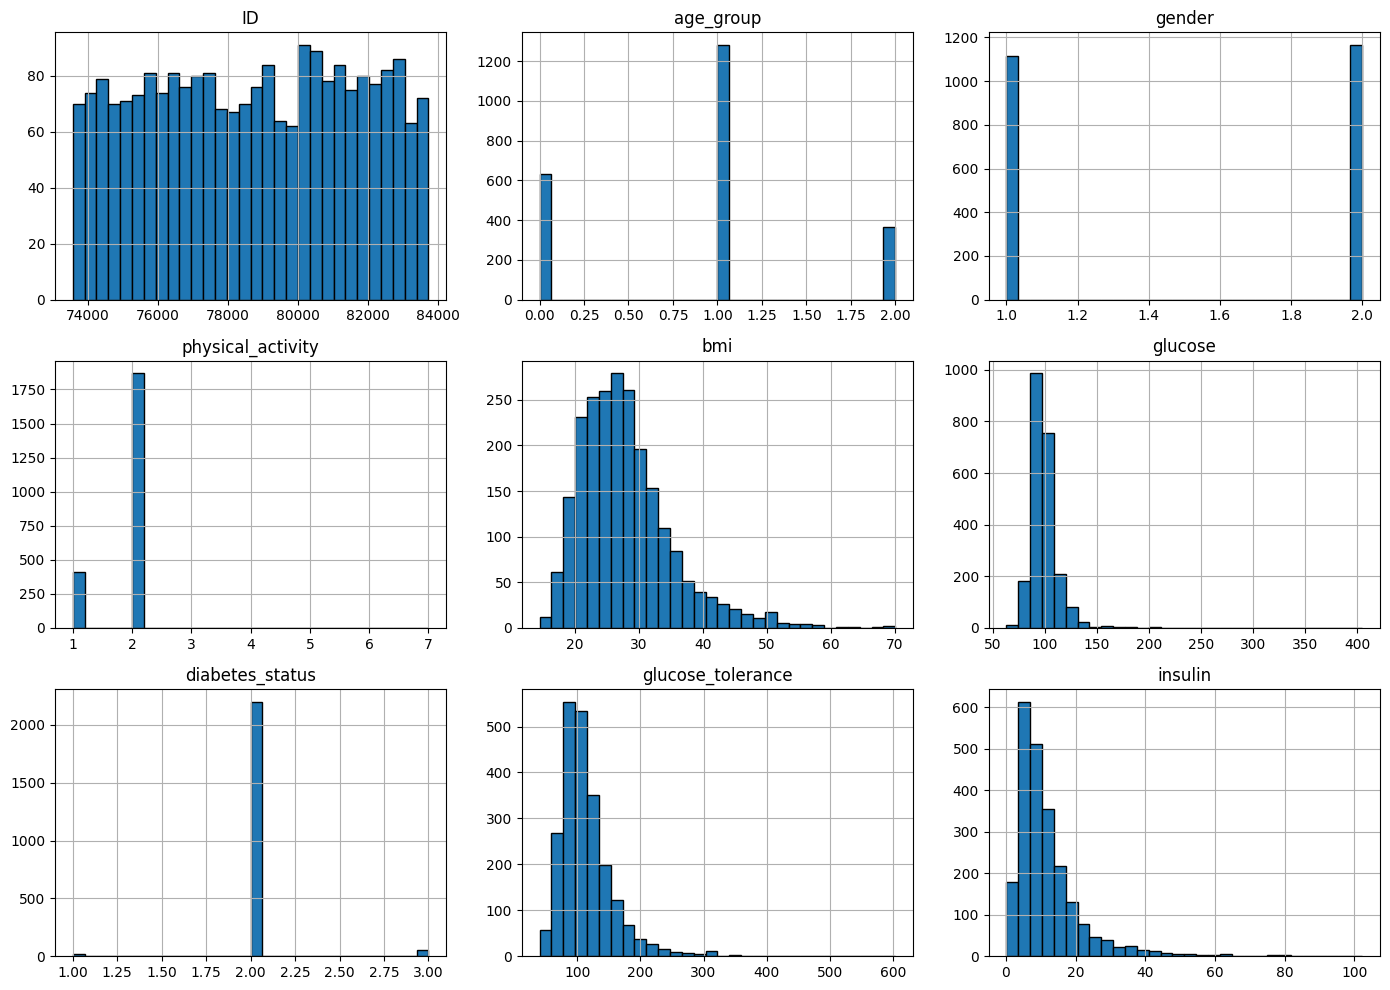

In [908]:
df.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

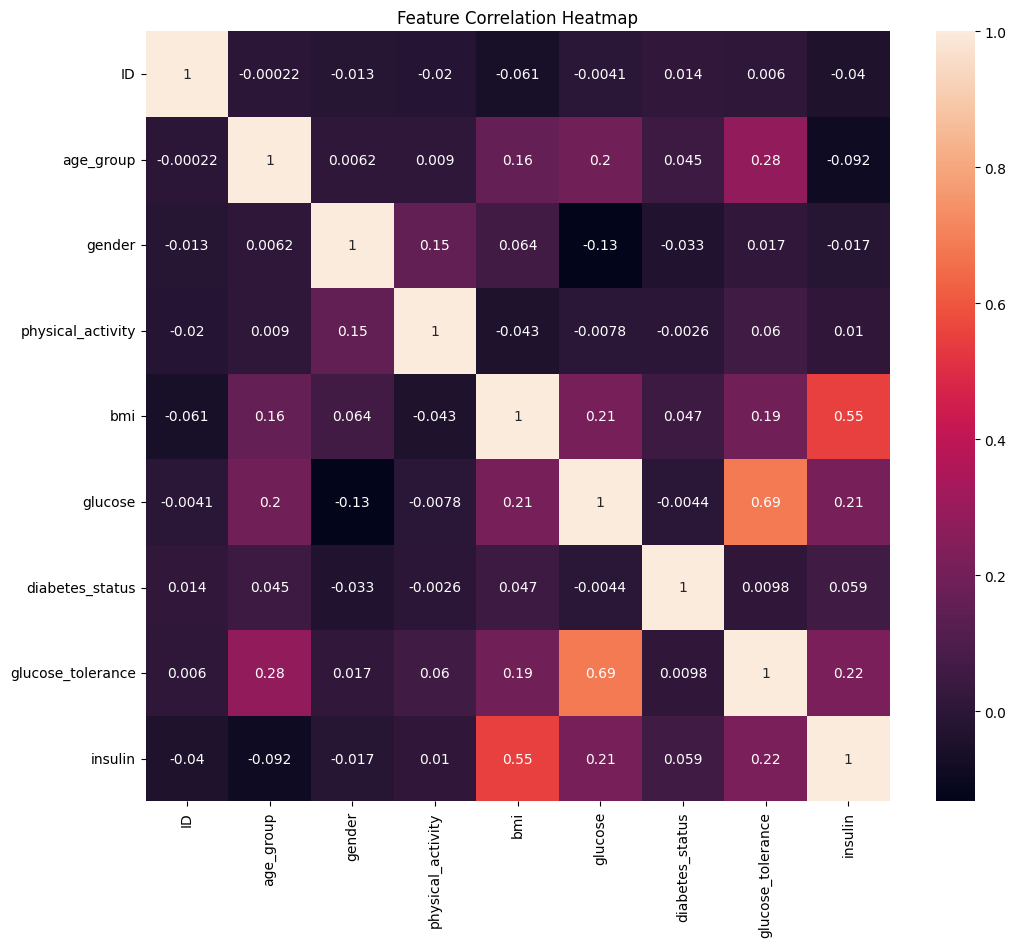

In [909]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

#### Cheking and removing outliers

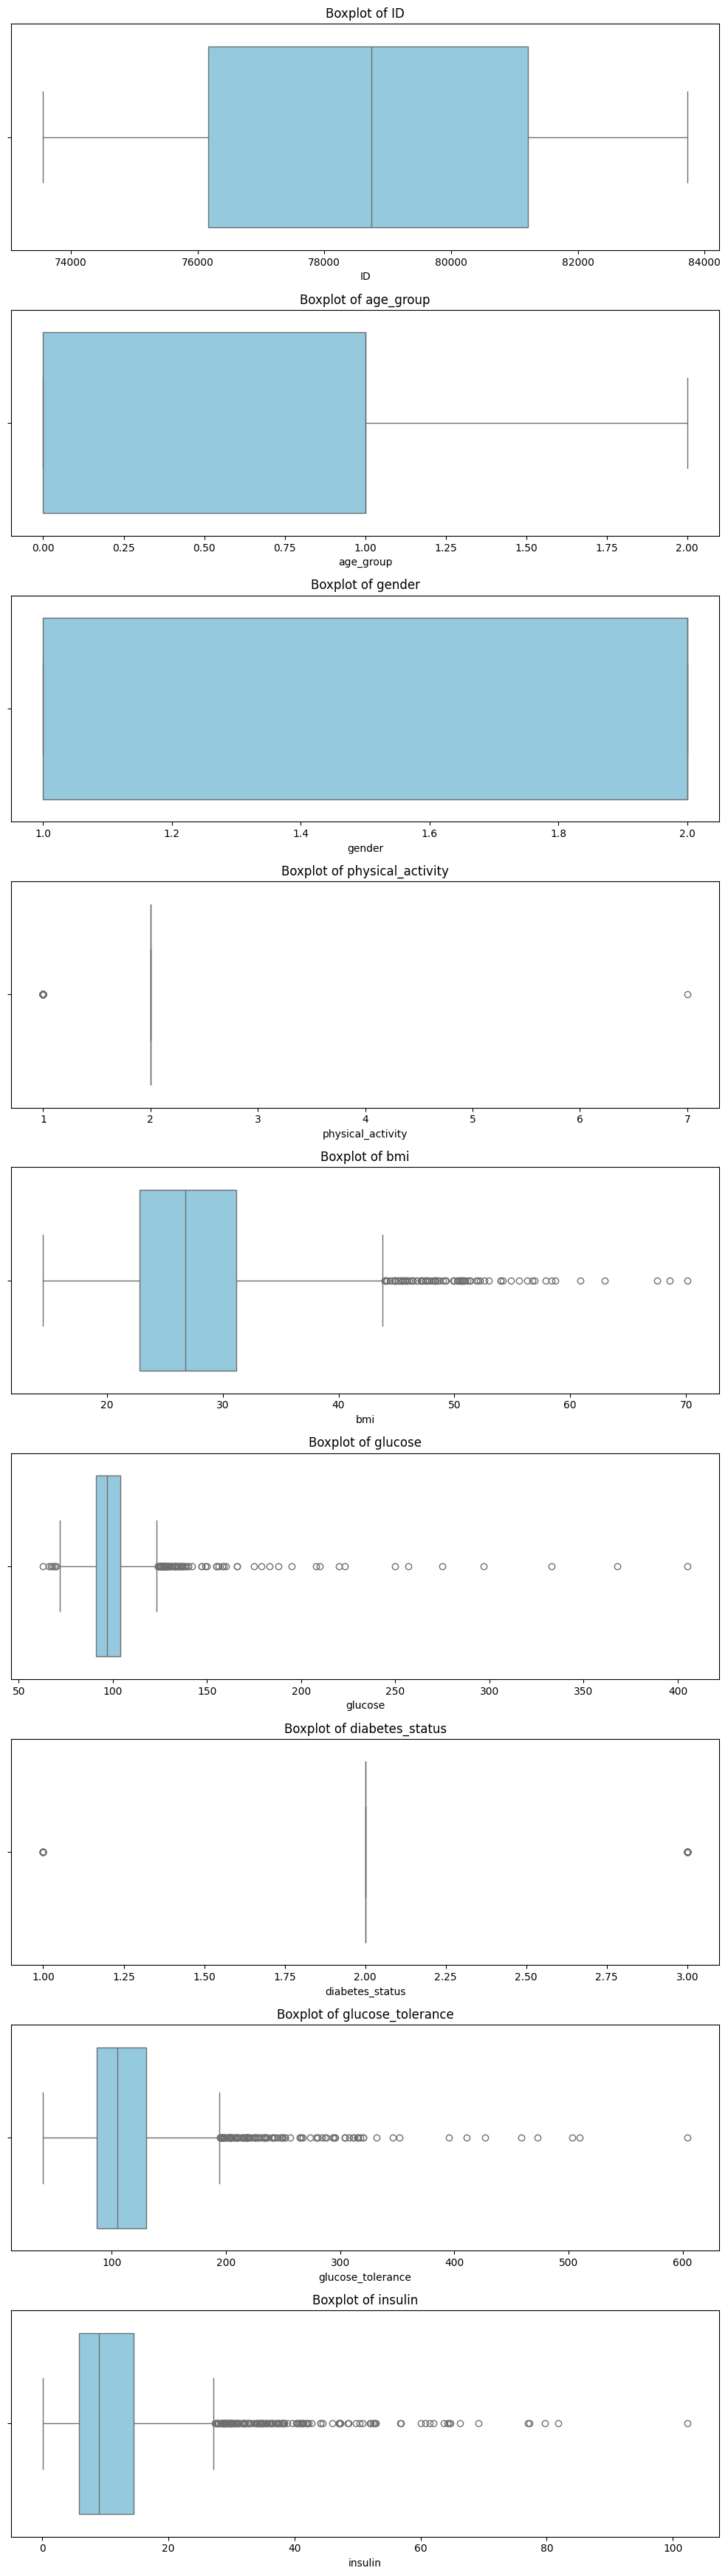

In [910]:
def check_outliers(df):
    fig, axs = plt.subplots(len(df.columns), 1, figsize=(10, 35))
    for i, col in enumerate(df.columns):
        sns.boxplot(x=df[col], ax=axs[i], color='skyblue')
        axs[i].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

check_outliers(df)

In [911]:
def drop_outliers(df, columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

num_cols = df.select_dtypes(include=np.number).columns

df = drop_outliers(df, num_cols)

#### Data Scaling

In [912]:
scaler = StandardScaler()
# df_scaled = df.copy()
# df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])
values_to_remove = ['age_group', 'gender', 'physical_activity', 'diabetes_status']
num_cols = num_cols[~num_cols.isin(values_to_remove)]
df[num_cols] = scaler.fit_transform(df[num_cols])

#### Splitting data into input features(X) and target variable(y).

In [913]:
X = df.drop(columns = 'age_group')
y = df['age_group']
df.head()

,ID,age_group,gender,physical_activity,bmi,glucose,diabetes_status,glucose_tolerance,insulin
0,-1.75988,1.0,2.0,2.0,1.704665,1.717420,2.0,1.560068,1.104244
1,-1.75852,1.0,2.0,2.0,-1.062045,-0.830799,2.0,-0.897772,-1.089946
2,-1.75580,0.0,1.0,2.0,-0.541042,-0.830799,2.0,-1.319116,-0.635633
3,-1.75546,1.0,1.0,2.0,0.483001,0.989357,2.0,-0.757324,1.350247
5,-1.75410,1.0,1.0,2.0,-0.469179,1.717420,2.0,-0.195532,-0.647537


# Model training and evaluation

1. Take models and train on X_train, y_train
2. Predict age_group
3. Plot metrics like accuracy_score, confussion_matrix, etc.
4. Tune hyperparameters of the models using tune_parameters.

In [914]:
def checkForOutliers(df):
    fig, axs = plt.subplots(len(df.columns),1,dpi=95, figsize=(7,30))
    axs = np.atleast_1d(axs) 
    for i, col in enumerate(df.columns):
        axs[i].boxplot(df[col], vert=False)
        axs[i].set_ylabel(col)
    plt.show()

def dropOutliers(df, drop_list):
    for col in drop_list:
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        clean_data = df[(df[col] > lower_bound) 
                        & (df[col] < upper_bound)]
        df = clean_data
    return df

# function to tune hyperparameters of a selected model
# how to write param_grid
param_grid = {
    'classification__penalty': ['l1', 'l2', 'elasticnet', None],
    'classification__max_iter': [100, 200, 500],
    'classification__solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'classification__multi_class': ['auto', 'ovr', 'multinomial']
}

def tune_hyperparams(model, param_grid, X_train, y_train):
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='roc_auc_ovr')
    pipeline = Pipeline([
        ('feature_selection', rfecv),
        ('classification', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(10), scoring='roc_auc_ovr', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

def train_predict_evaluate(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=np.nan, average='micro')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    print("\nModel:", str(model))
    print("| Accuracy score:", accuracy)
    print("| Precision score:", precision)
    print("| Recall score:", recall)
    print("| F1 score:", f1)
    print("| Confussion matrix:\n", cm)
    

In [915]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# model = LogisticRegression()
# train_predict_evaluate(model, X, y)

# model = KNeighborsClassifier()
# train_predict_evaluate(model, X, y) # cannot tune params

# model = DecisionTreeClassifier(random_state=0)
# train_predict_evaluate(model, X, y)

# model = RandomForestClassifier(random_state=0)
# train_predict_evaluate(model, X, y)

# model = SVC()
# train_predict_evaluate(model, X, y) # cannot tune params

# model = GaussianNB()
# train_predict_evaluate(model, X, y) # cannot tune params

# model = GradientBoostingClassifier(ccp_alpha= 0.01, loss= 'log_loss', max_depth= 2)
# train_predict_evaluate(model, X, y) 

# param_grid = {
#     # 'classification__max_depth': [2, 3, 5],
#     'classification__min_samples_leaf': [2, 3, 5],
#     'classification__ccp_alpha': [0.01, 0.1, 1],
#     'classification__min_samples_split': [2, 3],
# }

# tune_hyperparams(model, param_grid, X_train, y_train)

In [916]:
models = {
    'Logistic Regression (saga)': LogisticRegression(C=1, max_iter=200, penalty='l1', solver='saga'),
    'Logistic Regression (liblinear)': LogisticRegression(solver='liblinear'),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.01, max_depth=10, max_features='log2', min_samples_leaf=5, random_state=0),
    'Random Forest': RandomForestClassifier(ccp_alpha=0.01, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=0),
    'GaussianNB': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(ccp_alpha=0.01, loss='log_loss',min_samples_split=2, min_samples_leaf=2, max_depth=2)
}

results = {}

n_models = len(models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    train_sizes, train_scores, validation_scores = learning_curve(model, X_train, y_train, cv=5)
    
    y_test_bin = label_binarize(y_test, classes=[0.0, 1.0, 2.0]) 
    n_classes = y_test_bin.shape[1]
    fpr, tpr, roc_auc, precision_c, recall_c = {}, {}, {}, {}, {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        precision_c[i], recall_c[i], _ = precision_recall_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])

    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'fpr': fpr, 
        'tpr': tpr,
        'roc_curve': roc_auc,
        'precision_curve': precision_c,
        'recall_curve': recall_c,
        'train_sizes':train_sizes,
        'train_scores':train_scores,
        'validation_scores': validation_scores
        
    }


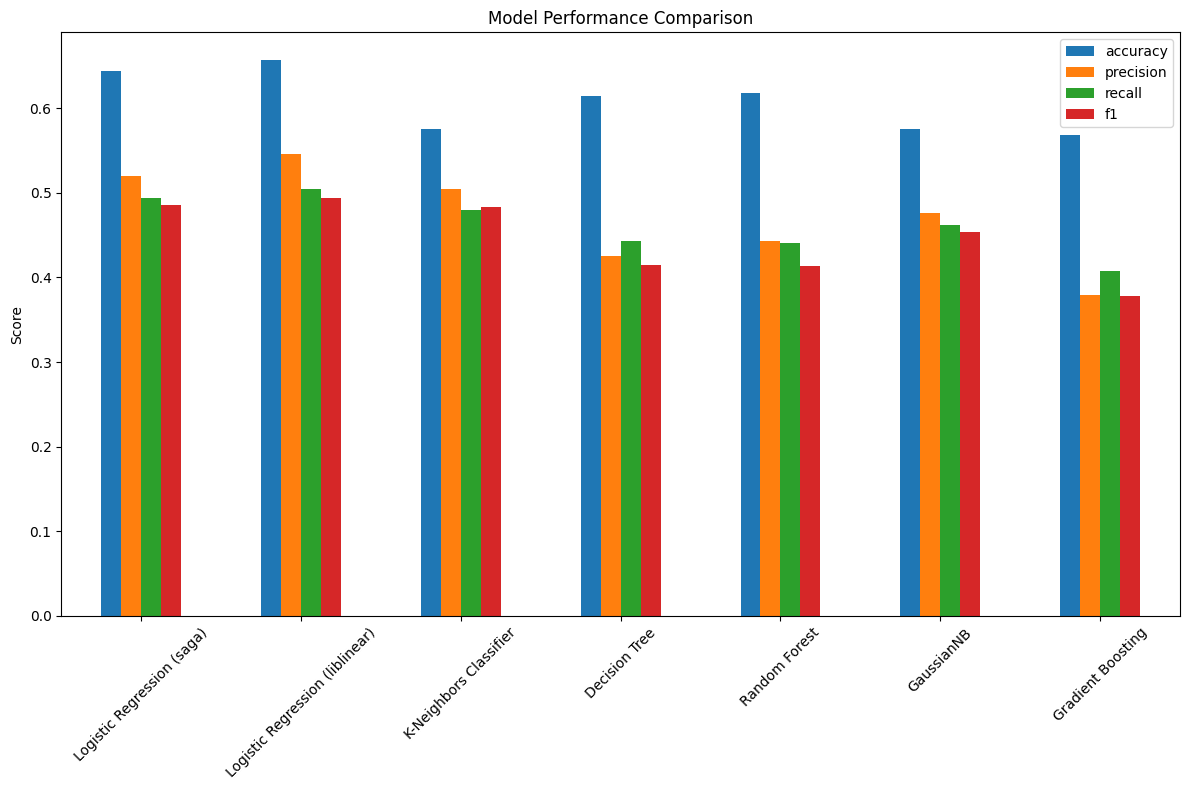

In [917]:
metrics_df = pd.DataFrame(results).T
metrics_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

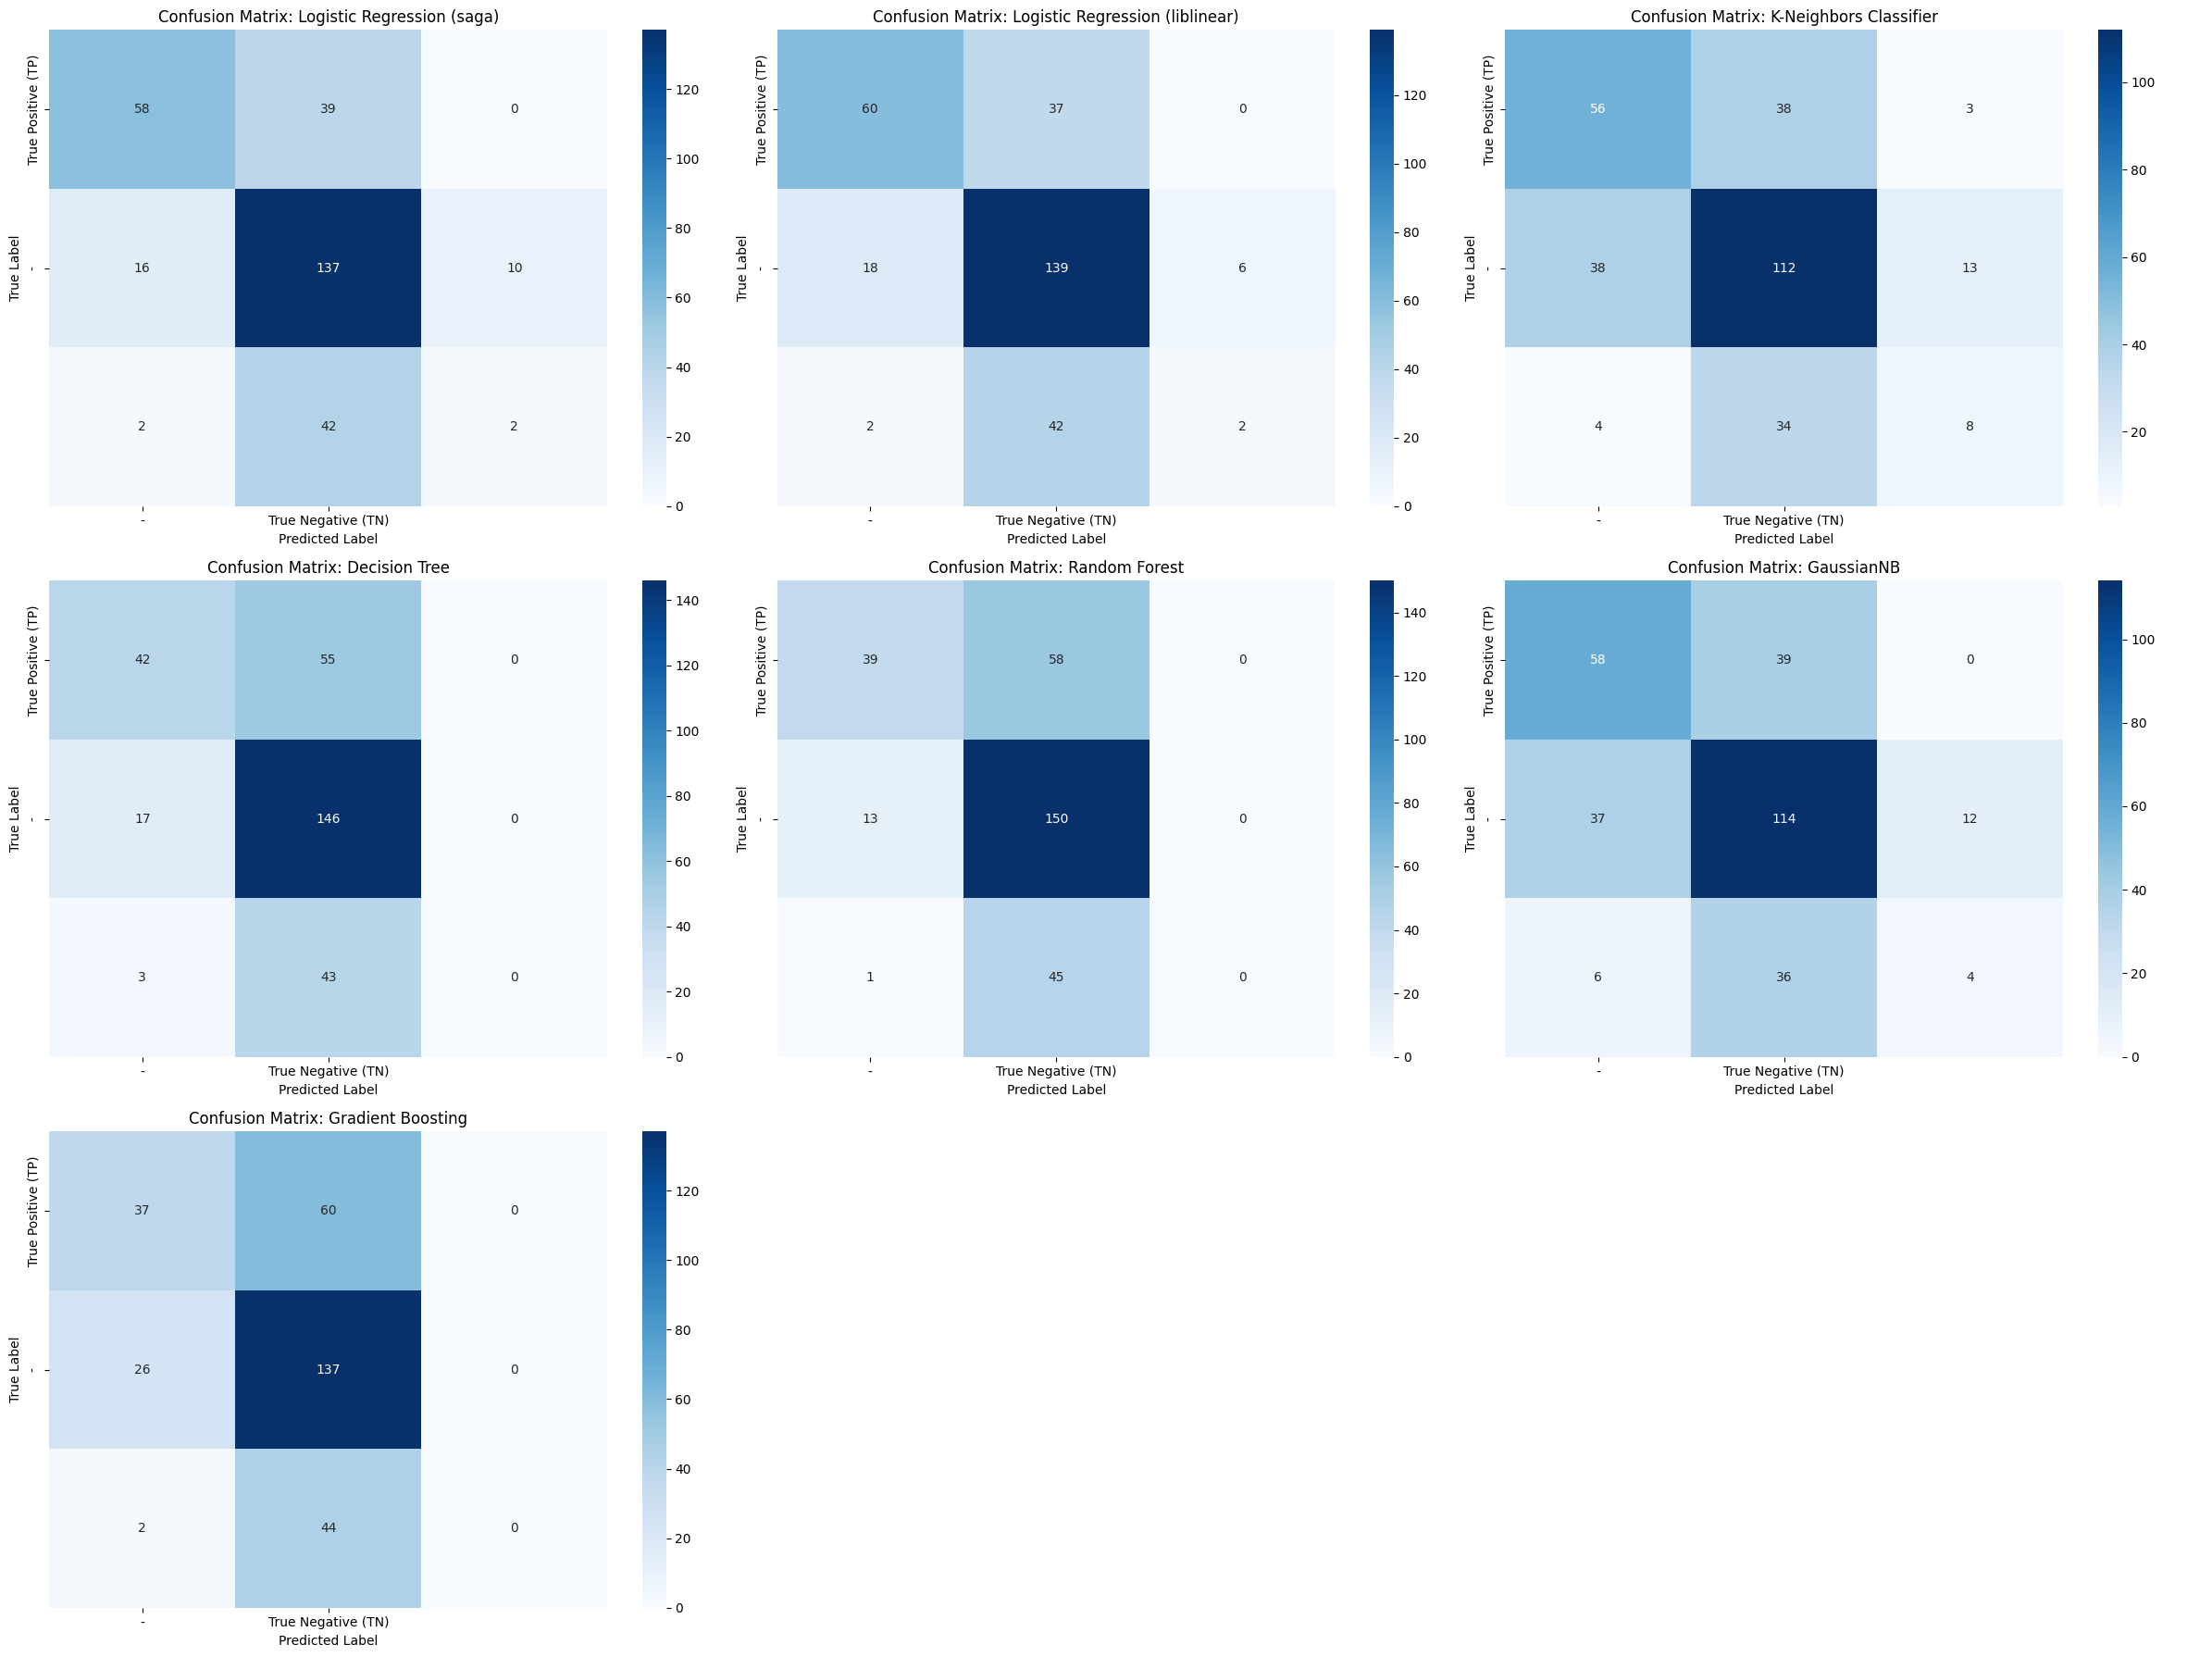

In [918]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
labels = ['-', 'True Negative (TN)', 'True Positive (TP)', '-']
for i, model_name in enumerate(models.keys()):
    cm = results[model_name]['confusion_matrix']
    cm_reshaped = cm.reshape(3, 3)
    sns.heatmap(cm_reshaped, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels[:2], yticklabels=labels[2:], ax=axes[i])  
    axes[i].set_title(f'Confusion Matrix: {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


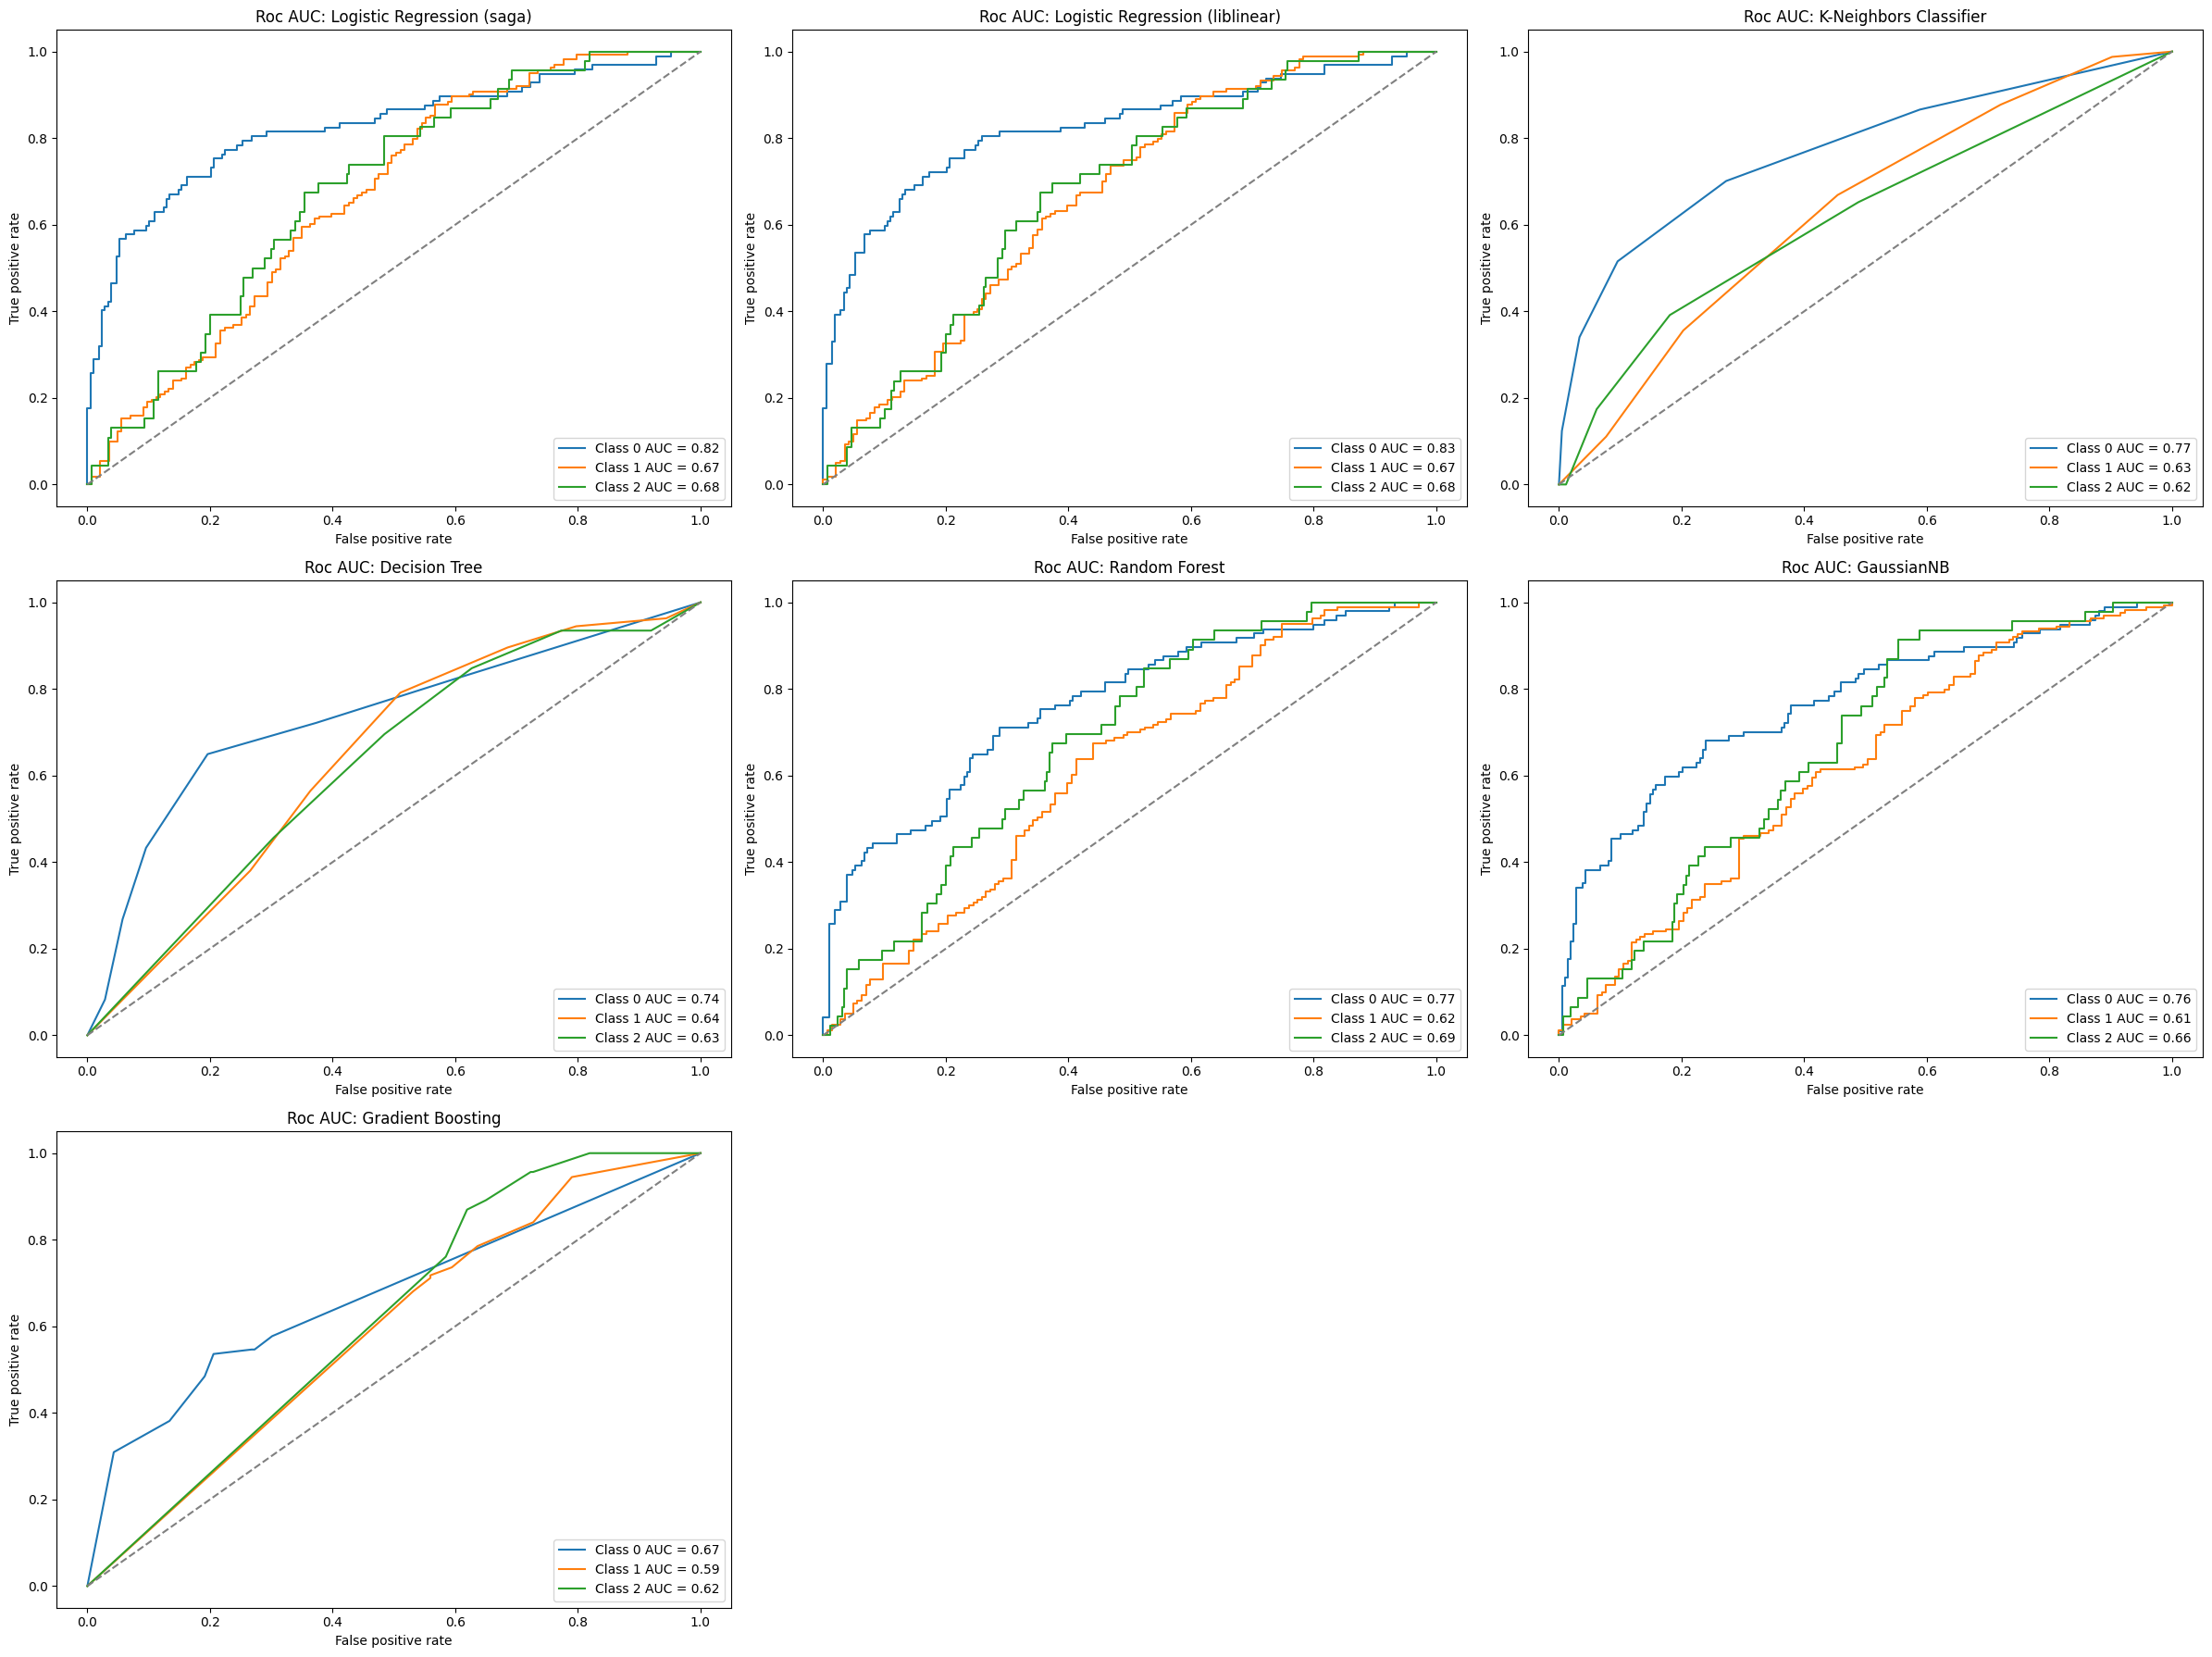

In [919]:

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    fpr = results[model_name]['fpr']
    tpr = results[model_name]['tpr']
    roc_auc = results[model_name]['roc_curve']
    for j in range(n_classes):
        axes[i].plot(fpr[j], tpr[j], label=f'Class {j} AUC = {roc_auc[j]:.2f}')
    axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[i].set_title(f'Roc AUC: {model_name}')
    axes[i].set_xlabel('False positive rate')
    axes[i].set_ylabel('True positive rate')
    axes[i].legend(loc='lower right')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


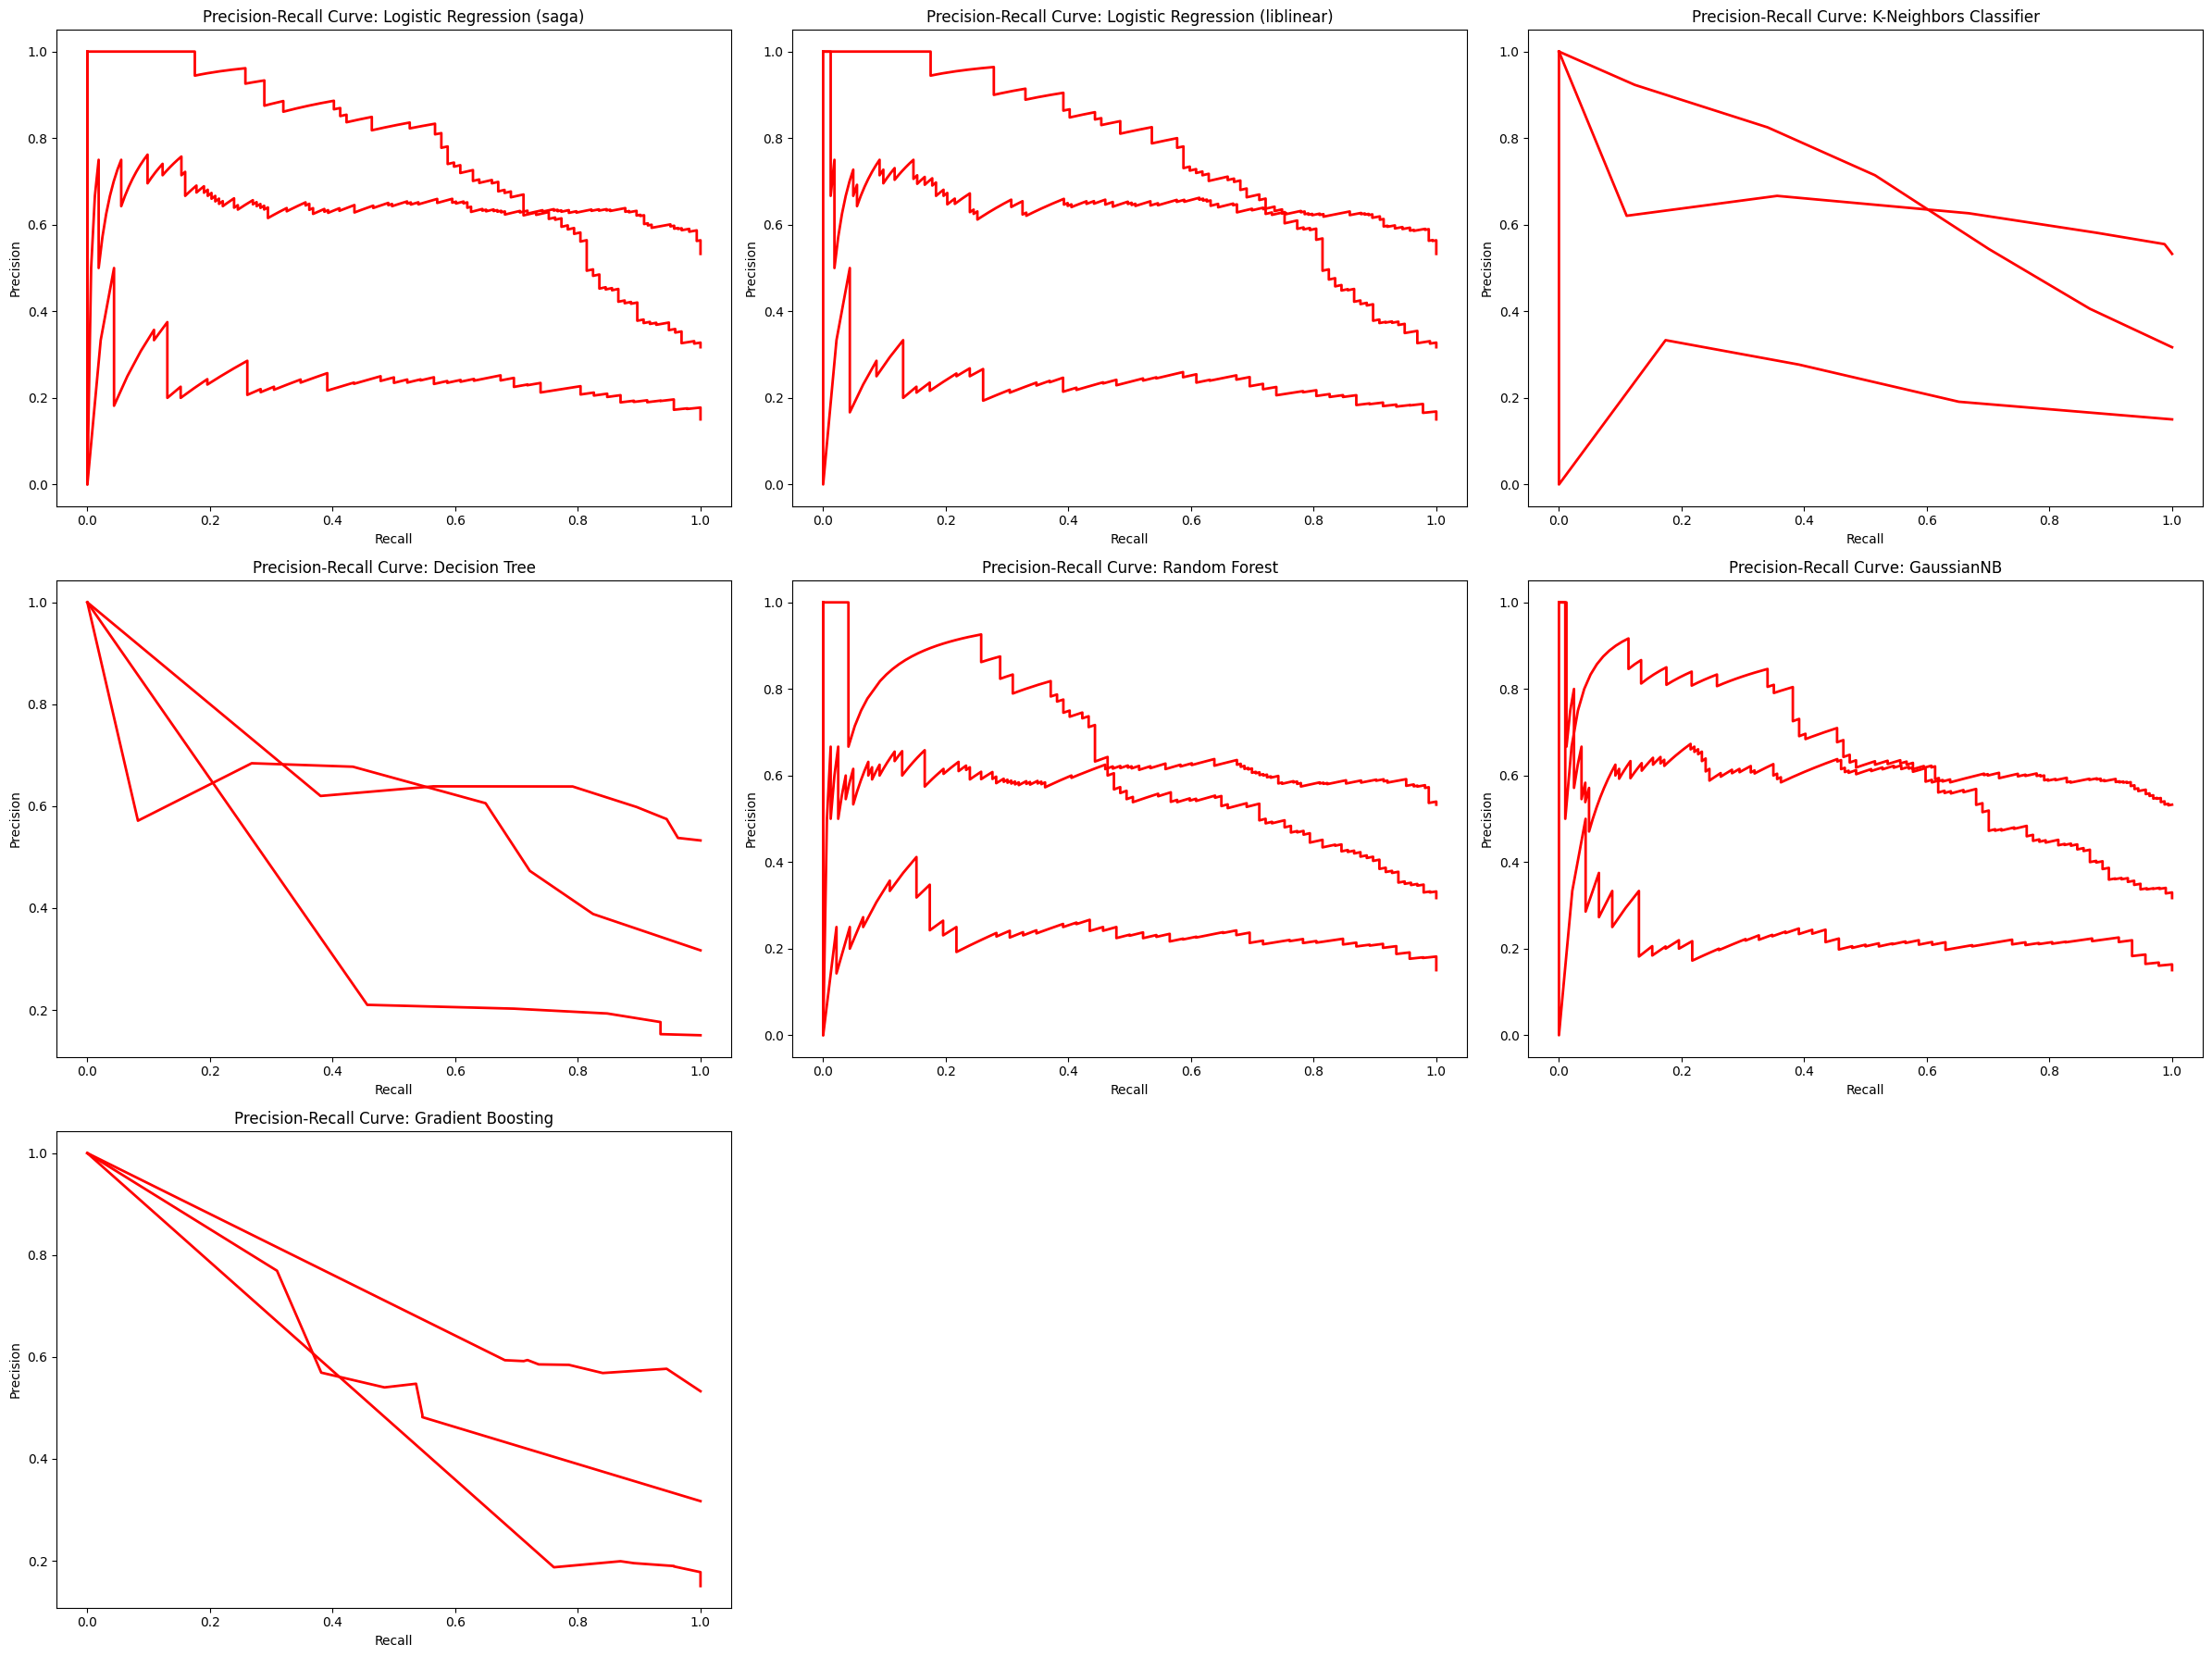

In [920]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    recall = results[model_name]['recall_curve']
    precision = results[model_name]['precision_curve']
    for j in range(n_classes):
        axes[i].plot(recall[j], precision[j], color='red', lw=2)
    axes[i].set_title(f'Precision-Recall Curve: {model_name}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

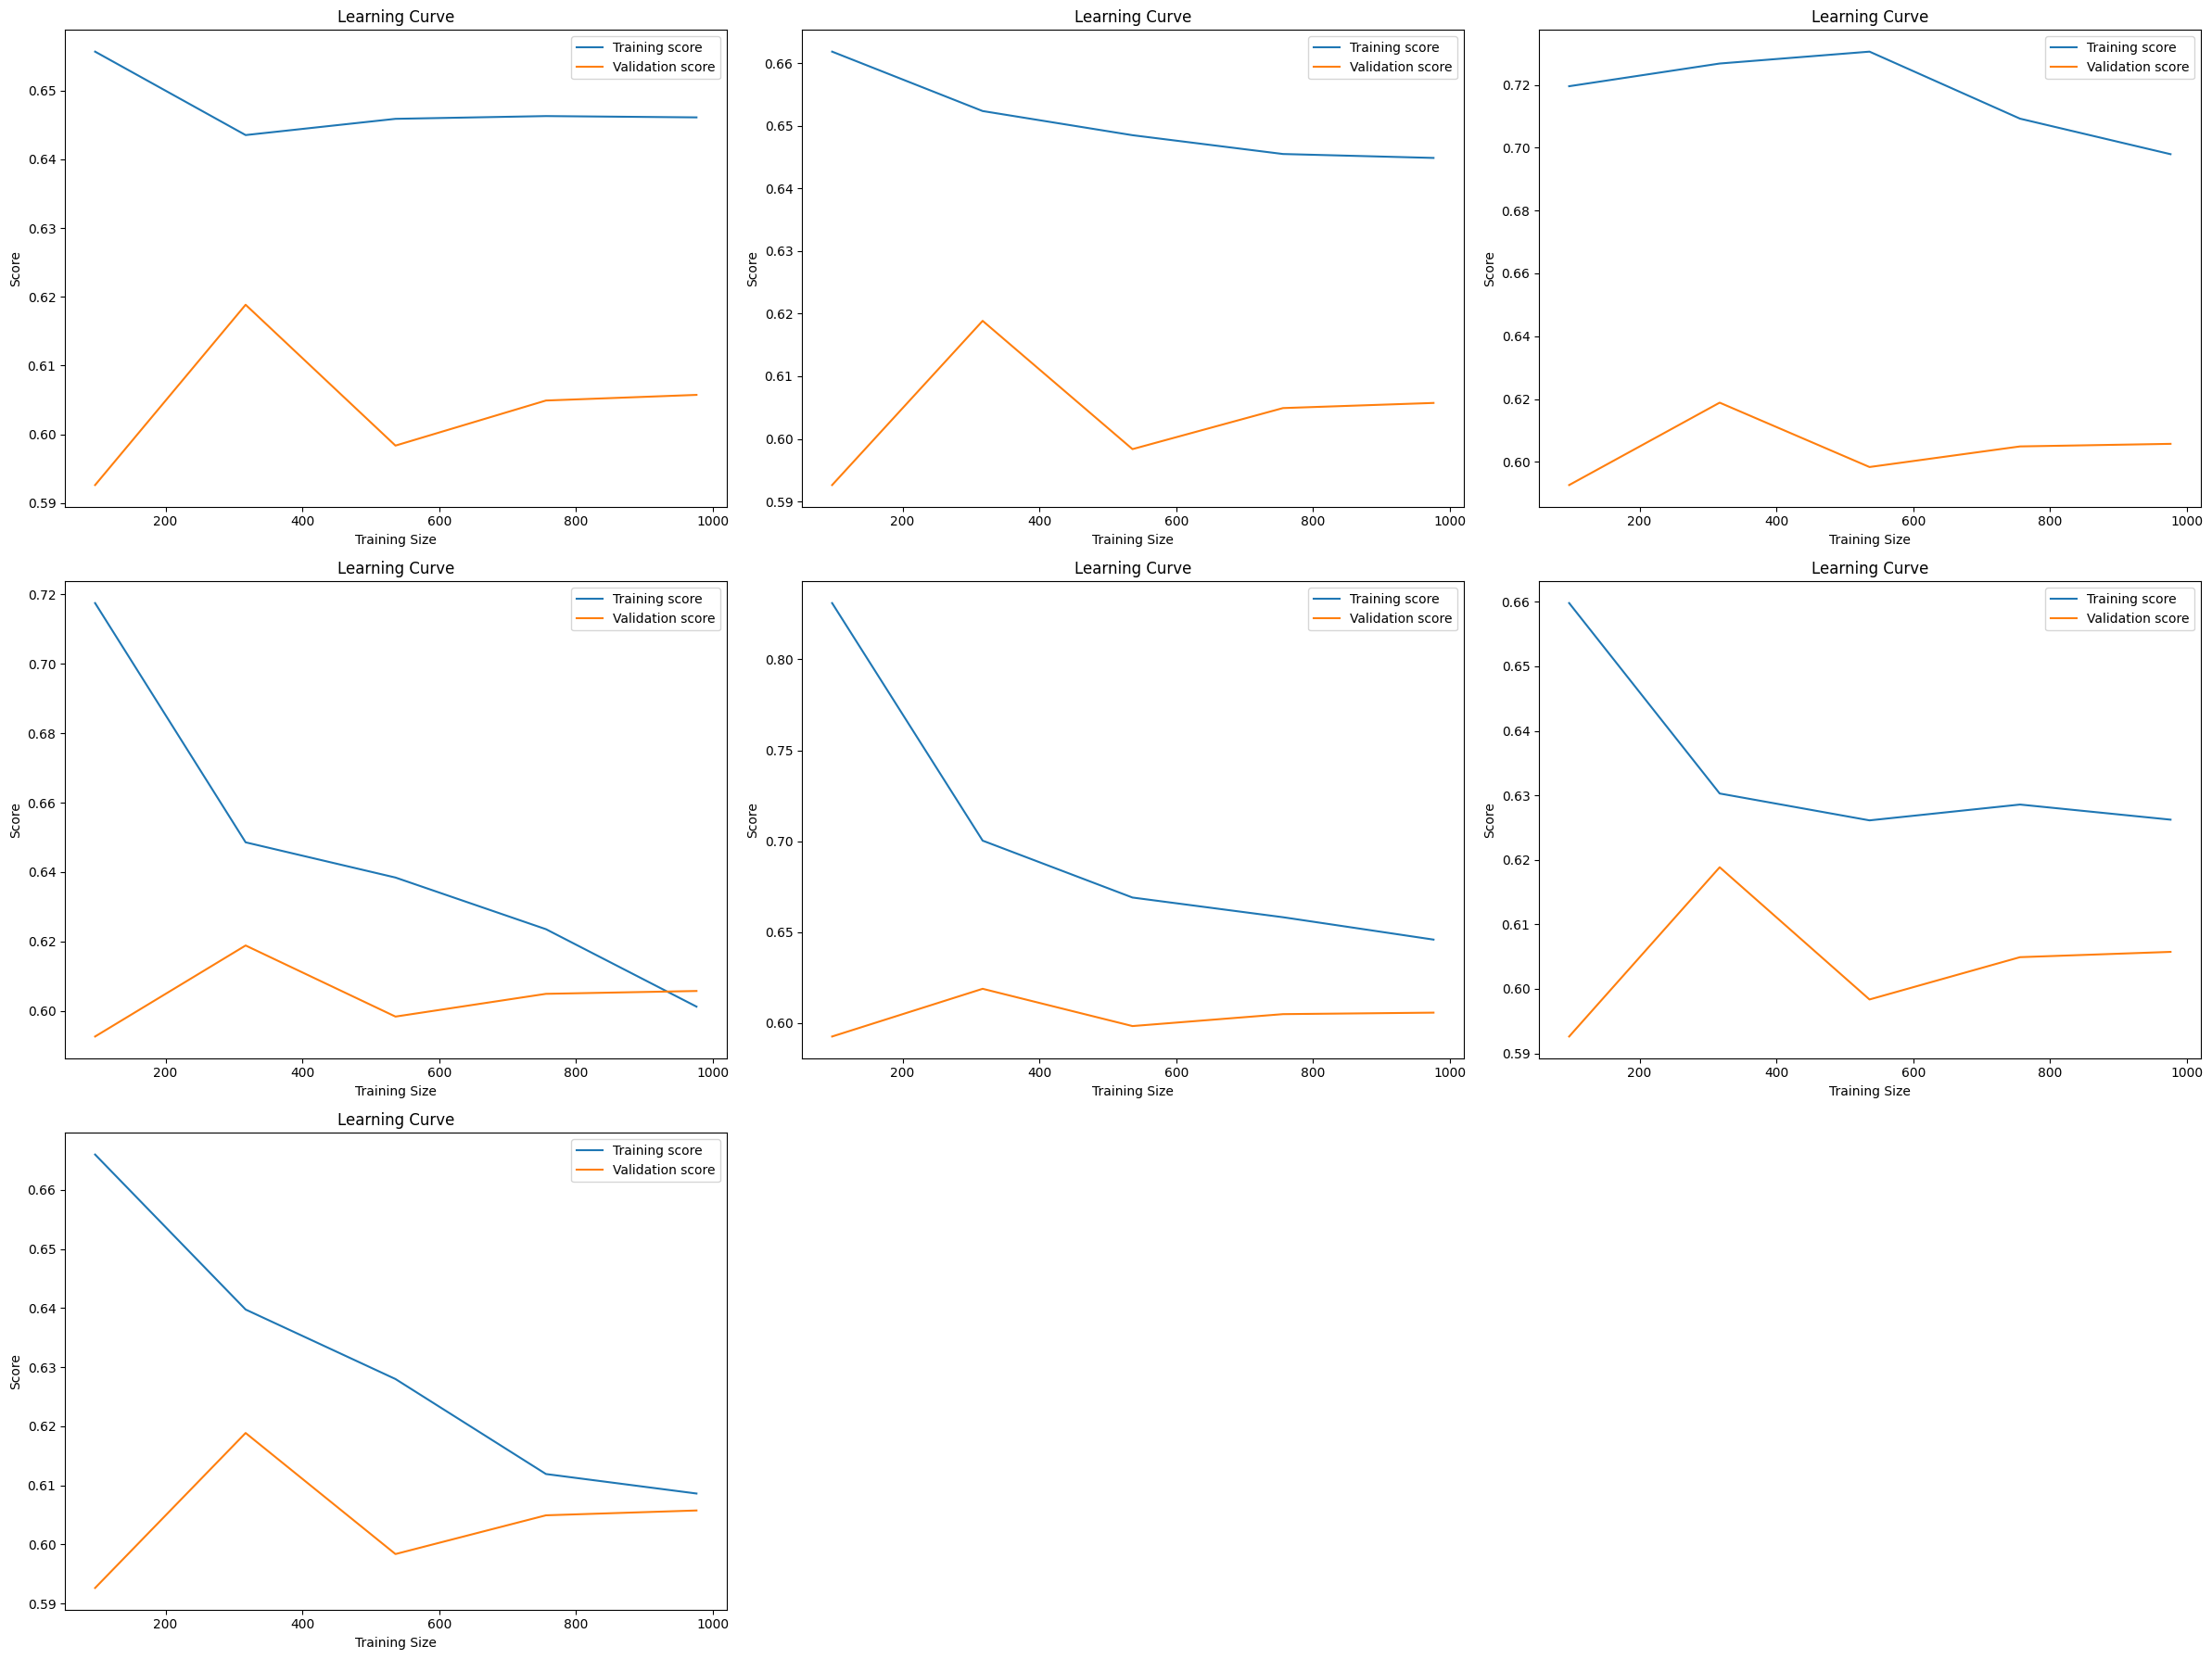

In [921]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    train_size = results[model_name]['train_sizes']
    train_scores = results[model_name]['train_scores']
    valid_scores = results[model_name]['validation_scores']
    param_range = np.arange(1, 10, 1)
    axes[i].plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    axes[i].plot(train_sizes, np.mean(validation_scores, axis=1), label='Validation score')
    axes[i].set_title('Learning Curve')
    axes[i].set_xlabel('Training Size')
    axes[i].set_ylabel('Score')
    axes[i].legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

### After trial and error, we've reached final model - Logistic Regression with liblinear solver. Even though other models perfomed quite similar to each other and showed similar scorings. (investigate why this model performed the best with such solver, is it our dataset or not enough data to make others work?)